# Project Steps

Goal: Predict the amount of gold recovered from gold ore.

1. Prepare the data
1.1. Open the files and look into the data.
Path to files:
/datasets/gold_recovery_train.csv
/datasets/gold_recovery_test.csv
/datasets/gold_recovery_full.csv
1.2. Check that recovery is calculated correctly. Using the training set, calculate recovery for the rougher.output.recovery feature. Find the MAE between your calculations and the feature values. Provide findings.
1.3. Analyze the features not available in the test set. What are these parameters? What is their type?
1.4. Perform data preprocessing.
2. Analyze the data
2.1. Take note of how the concentrations of metals (Au, Ag, Pb) change depending on the purification stage.
2.2. Compare the feed particle size distributions in the training set and in the test set. If the distributions vary significantly, the model evaluation will be incorrect.
2.3. Consider the total concentrations of all substances at different stages: raw feed, rougher concentrate, and final concentrate. Do you notice any abnormal values in the total distribution? If you do, is it worth removing such values from both samples? Describe the findings and eliminate anomalies.
3. Build the model
3.1. Write a function to calculate the final sMAPE value.
3.2. Train different models. Evaluate them using cross-validation. Pick the best model and test it using the test sample. Provide findings.
Use these formulas for evaluation metrics:
imageimage

In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from joblib import dump
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import mean_absolute_error
import numpy as np

# Goal: Predict the amount of gold recovered from gold ore.

In [2]:
gold_recovery_train = pd.read_csv('/datasets/gold_recovery_train.csv')
gold_recovery_test = pd.read_csv('/datasets/gold_recovery_test.csv')
gold_recovery_full = pd.read_csv('/datasets/gold_recovery_full.csv')

In [3]:
display(gold_recovery_train.describe())
display(gold_recovery_train.info())
display(gold_recovery_test.head(10))
display(gold_recovery_full.head(10))

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,16788.000000,16788.000000,16490.000000,16789.000000,15339.000000,16794.000000,16677.000000,16715.000000,16794.000000,15553.000000,...,16731.000000,16747.000000,16768.000000,16767.000000,16775.000000,16775.000000,16775.000000,16776.000000,16757.000000,16775.000000
mean,4.716907,9.113559,8.301123,39.467217,67.213166,8.757048,2.360327,9.303932,2.687512,129.479789,...,19.101874,-494.164481,14.778164,-476.600082,15.779488,-500.230146,12.377241,-498.956257,18.429208,-521.801826
std,2.096718,3.389495,3.825760,13.917227,11.960446,3.634103,1.215576,4.263208,1.272757,45.386931,...,6.883163,84.803334,5.999149,89.381172,6.834703,76.983542,6.219989,82.146207,6.958294,77.170888
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000003,...,0.000000,-799.920713,0.000000,-800.021781,-0.423260,-799.741097,0.427084,-800.258209,0.024270,-810.473526
25%,3.971262,8.825748,6.939185,42.055722,62.625685,7.610544,1.641604,7.870275,2.172953,103.064021,...,14.508299,-500.837689,10.741388,-500.269182,10.977713,-500.530594,8.925586,-500.147603,13.977626,-501.080595
50%,4.869346,10.065316,8.557228,44.498874,67.644601,9.220393,2.453690,10.021968,2.781132,131.783108,...,19.986958,-499.778379,14.943933,-499.593286,15.998340,-499.784231,11.092839,-499.933330,18.034960,-500.109898
75%,5.821176,11.054809,10.289741,45.976222,72.824595,10.971110,3.192404,11.648573,3.416936,159.539839,...,24.983961,-494.648754,20.023751,-400.137948,20.000701,-496.531781,15.979467,-498.418000,24.984992,-499.565540
max,16.001945,17.031899,18.124851,53.611374,100.000000,19.552149,6.086532,22.317730,9.789625,251.999948,...,60.000000,-127.692333,28.003828,-71.472472,63.116298,-275.073125,39.846228,-120.190931,54.876806,-39.784927


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  16860 non-null object
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant             

None

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333
5,2016-09-01 05:59:59,168.485085,8.817007,7.420000,0.791191,1402.826803,-499.299521,1401.511119,-499.205357,1404.088107,...,12.029797,-499.814895,8.036586,-500.371492,8.041446,-510.037054,4.983949,-499.990990,24.978973,-500.475640
6,2016-09-01 06:59:59,144.133440,7.924610,7.420000,0.788838,1398.252401,-499.748672,1393.255503,-499.195380,1396.738566,...,12.026296,-499.473127,8.027984,-500.983079,7.907340,-507.964971,5.010224,-500.043697,25.040709,-499.501984
7,2016-09-01 07:59:59,133.513396,8.055252,6.988000,0.801871,1401.669677,-501.777839,1400.754446,-502.514024,1400.465244,...,12.040911,-501.293852,8.020490,-499.185229,8.116897,-511.927561,5.036498,-500.149615,25.032580,-503.970657
8,2016-09-01 08:59:59,133.735356,7.999618,6.935000,0.789329,1402.358981,-499.981597,1400.985954,-496.802968,1401.168584,...,11.998184,-499.481608,8.012610,-500.896783,7.974422,-521.199104,5.061599,-499.791519,25.005063,-497.613716
9,2016-09-01 09:59:59,126.961069,8.017856,7.030000,0.805298,1400.816120,-499.014158,1399.975401,-499.570552,1401.871924,...,12.040725,-499.987743,7.989503,-499.750625,7.989710,-509.946737,5.068811,-499.293900,24.992741,-499.272255


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691
5,2016-01-15 05:00:00,6.482968,10.049416,5.480257,41.633678,69.465816,10.182708,0.664118,16.999638,1.918586,...,13.938497,-500.970168,11.883350,-500.395298,10.054147,-496.374715,7.965083,-499.364752,14.017067,-599.707915
6,2016-01-15 06:00:00,6.533849,10.058141,4.569100,41.995316,69.300835,10.304598,0.807342,16.723575,2.058913,...,14.046819,-500.971133,12.091543,-500.501426,10.003247,-497.083180,8.010890,-500.002423,14.029649,-600.905470
7,2016-01-15 07:00:00,6.130823,9.935481,4.389813,42.452727,70.230976,10.443288,0.949346,16.689959,2.143437,...,13.974691,-501.819696,12.101324,-500.583446,9.873169,-499.171928,7.993381,-499.794518,13.984498,-600.411070
8,2016-01-15 08:00:00,5.834140,10.071156,4.876389,43.404078,69.688595,10.420140,1.065453,17.201948,2.209881,...,13.964030,-504.252450,12.060738,-501.174549,10.033838,-501.178133,7.881604,-499.729434,13.967135,-599.061188
9,2016-01-15 09:00:00,5.687063,9.980404,5.282514,43.235220,70.279619,10.487013,1.159805,17.483979,2.209593,...,13.989632,-503.195299,12.052233,-500.928547,9.962574,-502.986357,7.979219,-500.146835,13.981614,-598.070855


In [4]:
print('length of training set:',len(gold_recovery_train))
print('length of test set:', len(gold_recovery_test))
print('length of full set:', len(gold_recovery_full))

length of training set: 16860
length of test set: 5856
length of full set: 22716


# Data Preprocessing

In [5]:
gold_recovery_full.dropna(subset = ['rougher.output.recovery','final.output.recovery'], inplace=True)

def clean_data(df, column_name):
    df[column_name].fillna(df[column_name].median(), inplace=True)
    index = df[df[column_name] < .001].index
    df.loc[index, column_name] = df[column_name].median()
#    Q1 = df[column_name].quantile(0.25)
#    Q3 = df[column_name].quantile(0.75)
#    IQR = Q3-Q1
#    LF = Q1 - IQR*1.5
#    RF = Q3 + IQR*1.5
#    index = df[(df[column_name] > RF) | (df[column_name] < LF)].index
#    df.loc[index, column_name] = df[column_name].median()
    return df

len(gold_recovery_full)

19439

Explanation: We created a function to remove outliers and also replace missing data with the median.

## Clean Up the Full Data Set

In [6]:
columns = gold_recovery_full.columns.drop('date')
for n in columns:
    clean_data(gold_recovery_full, n)

gold_recovery_full.head(20)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-499.837793,12.099931,-499.459786,9.925633,-499.802605,8.079666,-499.935317,14.151341,-500.0484
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-499.837793,11.950531,-499.459786,10.039245,-499.802605,7.984757,-499.935317,13.998353,-500.0484
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-499.837793,11.912783,-499.459786,10.070913,-499.802605,8.013877,-499.935317,14.028663,-500.0484
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-499.837793,11.999550,-499.459786,9.970366,-499.802605,7.977324,-499.935317,14.005551,-500.0484
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.837793,11.953070,-499.459786,9.925709,-499.802605,7.894242,-499.935317,13.996647,-500.0484
5,2016-01-15 05:00:00,6.482968,10.049416,5.480257,41.633678,69.465816,10.182708,0.664118,16.999638,1.918586,...,13.938497,-499.837793,11.883350,-499.459786,10.054147,-499.802605,7.965083,-499.935317,14.017067,-500.0484
6,2016-01-15 06:00:00,6.533849,10.058141,4.569100,41.995316,69.300835,10.304598,0.807342,16.723575,2.058913,...,14.046819,-499.837793,12.091543,-499.459786,10.003247,-499.802605,8.010890,-499.935317,14.029649,-500.0484
7,2016-01-15 07:00:00,6.130823,9.935481,4.389813,42.452727,70.230976,10.443288,0.949346,16.689959,2.143437,...,13.974691,-499.837793,12.101324,-499.459786,9.873169,-499.802605,7.993381,-499.935317,13.984498,-500.0484
8,2016-01-15 08:00:00,5.834140,10.071156,4.876389,43.404078,69.688595,10.420140,1.065453,17.201948,2.209881,...,13.964030,-499.837793,12.060738,-499.459786,10.033838,-499.802605,7.881604,-499.935317,13.967135,-500.0484
9,2016-01-15 09:00:00,5.687063,9.980404,5.282514,43.235220,70.279619,10.487013,1.159805,17.483979,2.209593,...,13.989632,-499.837793,12.052233,-499.459786,9.962574,-499.802605,7.979219,-499.935317,13.981614,-500.0484


Explanation: We used our previous function 'replace_outliers' and applied it to the entrie dataframe
minus the date column. We did this by applying a for loop on every column in the dataframe. Down below we can see that this strategy worked.

In [7]:
gold_recovery_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19439 entries, 0 to 22715
Data columns (total 87 columns):
date                                                  19439 non-null object
final.output.concentrate_ag                           19439 non-null float64
final.output.concentrate_pb                           19439 non-null float64
final.output.concentrate_sol                          19439 non-null float64
final.output.concentrate_au                           19439 non-null float64
final.output.recovery                                 19439 non-null float64
final.output.tail_ag                                  19439 non-null float64
final.output.tail_pb                                  19439 non-null float64
final.output.tail_sol                                 19439 non-null float64
final.output.tail_au                                  19439 non-null float64
primary_cleaner.input.sulfate                         19439 non-null float64
primary_cleaner.input.depressant             

## Create New Test Set Out of Full Set

In [8]:
gold_recovery_test.info()
dates = gold_recovery_test["date"]
gold_recovery_test = gold_recovery_full.query('date in @dates')
gold_recovery_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
date                                          5856 non-null object
primary_cleaner.input.sulfate                 5554 non-null float64
primary_cleaner.input.depressant              5572 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5690 non-null float64
primary_cleaner.state.floatbank8_a_air        5840 non-null float64
primary_cleaner.state.floatbank8_a_level      5840 non-null float64
primary_cleaner.state.floatbank8_b_air        5840 non-null float64
primary_cleaner.state.floatbank8_b_level      5840 non-null float64
primary_cleaner.state.floatbank8_c_air        5840 non-null float64
primary_cleaner.state.floatbank8_c_level      5840 non-null float64
primary_cleaner.state.floatbank8_d_air        5840 non-null float64
primary_cleaner.state.floatbank8_d_level      5840 non-null float64
rougher.in

## Create New Training Set Out of Full Set

In [9]:
gold_recovery_train.info()
dates = gold_recovery_train["date"]
gold_recovery_train = gold_recovery_full.query('date in @dates')
gold_recovery_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  16860 non-null object
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant             

# Write Recovery Function

In [10]:
def recovery(row):
    c = row['rougher.output.concentrate_au']
    f = row['rougher.input.feed_au']
    t = row['rougher.output.tail_au']
    recovery = ( (c*(f-t))/(f*(c-t)) ) * 100
    return recovery

## Calculate Recovery

In [11]:
calc_recovery = gold_recovery_train.apply(recovery, axis=1)

calc_recovery.fillna(calc_recovery.median(), inplace=True)

gold_recovery_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14149 entries, 0 to 22715
Data columns (total 87 columns):
date                                                  14149 non-null object
final.output.concentrate_ag                           14149 non-null float64
final.output.concentrate_pb                           14149 non-null float64
final.output.concentrate_sol                          14149 non-null float64
final.output.concentrate_au                           14149 non-null float64
final.output.recovery                                 14149 non-null float64
final.output.tail_ag                                  14149 non-null float64
final.output.tail_pb                                  14149 non-null float64
final.output.tail_sol                                 14149 non-null float64
final.output.tail_au                                  14149 non-null float64
primary_cleaner.input.sulfate                         14149 non-null float64
primary_cleaner.input.depressant             

## MAE between calculations and feature values

In [12]:
mae = mean_absolute_error(calc_recovery, gold_recovery_train['rougher.output.recovery'])

print('MAE for calc recovery & rougher.ouput.recovery:', mae)

MAE for calc recovery & rougher.ouput.recovery: 0.14077132618604116


### Explanation:
- We used our function to calculate the Mean Absolute Error between our calculated rougher out recovery and the given rougher.output.recovery. We recieved a MAE value of 2.29.
- This value is low enough for us to consider the given rougher.output.recovery value to be accurate.

# Analyze the Data

## Observe Change in Concentration for Au:

<Figure size 720x720 with 0 Axes>

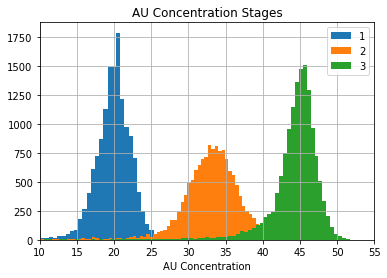

<Figure size 720x720 with 0 Axes>

In [13]:
gold_recovery_train['rougher.output.concentrate_au'].hist(bins=50)
gold_recovery_train['primary_cleaner.output.concentrate_au'].hist(bins=100)
gold_recovery_train['final.output.concentrate_au'].hist(bins=100)


plt.xlim(10,55)
#plt.ylim(0,1000)
plt.xlabel('AU Concentration')
plt.legend('1234')
plt.title('AU Concentration Stages')
plt.figure(figsize= (10,10))

### Explanation:
- The above histogram plots show how the AU concentration increases with every filtration stage.

## Observe Change in Concentration for Ag

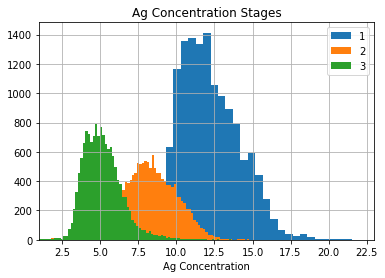

In [14]:
gold_recovery_train['rougher.output.concentrate_ag'].hist(bins=50)
gold_recovery_train['primary_cleaner.output.concentrate_ag'].hist(bins=100)
gold_recovery_train['final.output.concentrate_ag'].hist(bins=100)


plt.xlim(1,23)
#plt.ylim(0,1000)
plt.xlabel('Ag Concentration')
plt.legend('1234')
plt.title('Ag Concentration Stages')
plt.show()



### Explanation:
- The above histogram shows the concentration for Ag decreases in every stage.

## Observe Change in Concentration for Pb

Text(0.5, 1.0, 'Pb Concentration Stages')

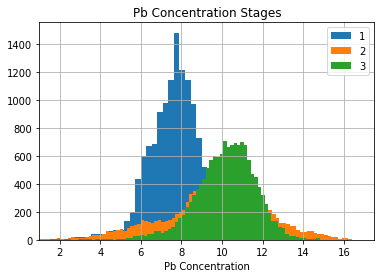

In [15]:
gold_recovery_train['rougher.output.concentrate_pb'].hist(bins=50)
gold_recovery_train['primary_cleaner.output.concentrate_pb'].hist(bins=100)
gold_recovery_train['final.output.concentrate_pb'].hist(bins=100)

plt.xlim(1,17.5)
#plt.ylim(0,800)
plt.xlabel('Pb Concentration')
plt.legend('1234')
plt.title('Pb Concentration Stages')


### Explanation:
- The concentration for lead decreases after each stage.

## Compare the feed particle size distributions

## Compare Primary Feed Size for Training and Test Sets

Text(0.5, 1.0, 'Training & Test Distributions for Primary Input Feed Size')

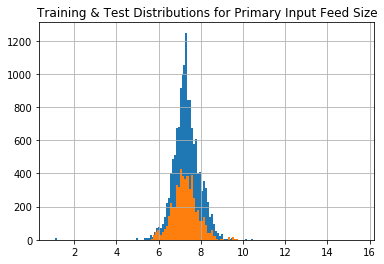

In [16]:
gold_recovery_train['primary_cleaner.input.feed_size'].hist(bins=100)
gold_recovery_test['primary_cleaner.input.feed_size'].hist(bins=100)
plt.title('Training & Test Distributions for Primary Input Feed Size')

### Explanation:
- The feed size distributions look similar. Therefore the model evaluations should yield correct resulsts.

## Compare Rougher Feed Size for Training and Test Sets

Text(0.5, 1.0, 'Training & Test Distributions for Rougher Input Feed Size')

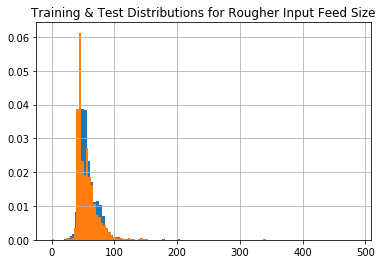

In [17]:

gold_recovery_train['rougher.input.feed_size'].hist(bins=100, density=True)
gold_recovery_test['rougher.input.feed_size'].hist(bins=100, density=True)
plt.title('Training & Test Distributions for Rougher Input Feed Size')


### Explanation:
- The feed size distributions look similar. Therefore the model evaluations should yield correct resulsts.

# Total Concentration Distributions:

## Raw Feed Stage using Training Data:

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


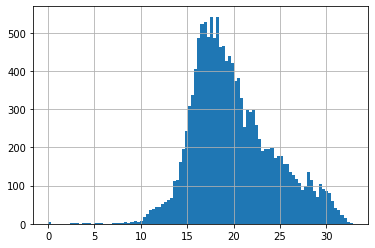

In [18]:
gold_recovery_train['total_concentration'] = gold_recovery_train['rougher.input.feed_ag'] + gold_recovery_train['rougher.input.feed_au'] + gold_recovery_train['rougher.input.feed_pb']

gold_recovery_train['total_concentration'].hist(bins=100)


## Raw Feed Stage Using Test Data:

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


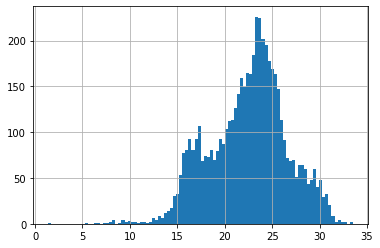

In [19]:
gold_recovery_test['total_raw_concentration'] = gold_recovery_test['rougher.input.feed_ag'] + gold_recovery_test['rougher.input.feed_au'] + gold_recovery_test['rougher.input.feed_pb']

gold_recovery_test['total_raw_concentration'].hist(bins=100)


## Rougher Concentrate Using Training Data

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


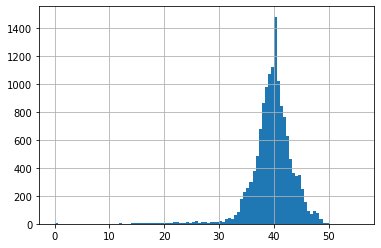

In [20]:
gold_recovery_train['total_rougher_concentration'] = gold_recovery_train['rougher.output.concentrate_ag'] + gold_recovery_train['rougher.output.concentrate_au'] + gold_recovery_train['rougher.output.concentrate_pb']

gold_recovery_train['total_rougher_concentration'].hist(bins=100)

## Rougher Concentrate Using Test Data

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


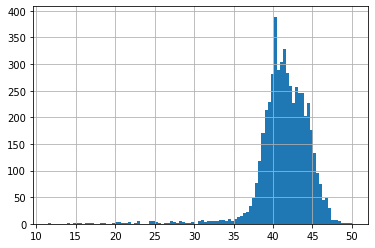

In [21]:
gold_recovery_test['total_rougher_concentration'] = gold_recovery_test['rougher.output.concentrate_ag'] + gold_recovery_test['rougher.output.concentrate_au'] + gold_recovery_test['rougher.output.concentrate_pb']

gold_recovery_test['total_rougher_concentration'].hist(bins=100)


## Final Output Concentration Using Training Data

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


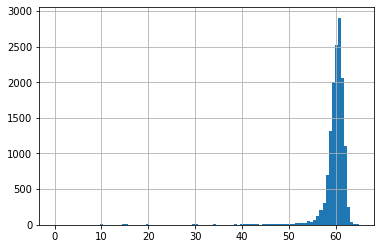

In [22]:
gold_recovery_train['total_final_concentration'] = gold_recovery_train['final.output.concentrate_ag'] + gold_recovery_train['final.output.concentrate_au'] + gold_recovery_train['final.output.concentrate_pb']

gold_recovery_train['total_final_concentration'].hist(bins=100)

## Final Output Concentration Using Test Data

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


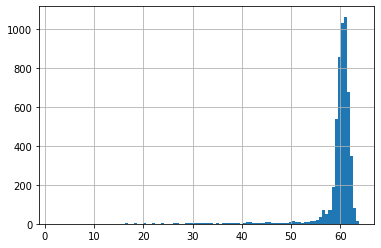

In [23]:
gold_recovery_test['total_final_concentration'] = gold_recovery_test['final.output.concentrate_ag'] + gold_recovery_test['final.output.concentrate_au'] + gold_recovery_test['final.output.concentrate_pb']

gold_recovery_test['total_final_concentration'].hist(bins=100)


## Explanation:
- For all the above distributions we found minimal anomalies, abnormal values, and outliers.
  This is because we took the full dataset at the beginning of the project and preprocessed the data.
- We can see a spike in frequency at the median becasue we took outliers and replaced them with median value.

# Build & Compare Models

## Function sMAPE

In [24]:
def smape(target, prediction):
    x=0
    y=0
    z=0
    for i in range(len(target)):
        x = abs(target[i]-prediction[i])
        y = abs(target[i])+abs(prediction[i])
        z += x / (y/2)        
    smape = z / len(target)
    return smape

## Linear Regression

### Predict Rougher Output Recovery

In [25]:
target_train = gold_recovery_train['rougher.output.recovery']
features_train = gold_recovery_train.drop(['date', 'rougher.output.recovery'] , axis=1)

target_test = gold_recovery_test['rougher.output.recovery']
features_test = gold_recovery_test.drop(['date', 'rougher.output.recovery'] , axis=1)

model = LinearRegression()
model.fit(features_train, target_train)

predicted_target = model.predict(features_test)

In [26]:
predicted_target = pd.Series(predicted_target)

In [27]:
target = gold_recovery_test['rougher.output.recovery'].reset_index(drop=True)

### sMAPE for Rougher Output Recovery

In [28]:
smape_rough = smape(target,predicted_target)
print('smape_rough:', smape_rough)

smape_rough: 0.017560860713868545


### Linear Regression Cross Validation Score

In [29]:
scores = cross_val_score(model, features_train, target_train, cv=5, scoring = make_scorer(mean_absolute_error, greater_is_better=False))
final_score = scores.sum()/len(scores)

print('Average model evaluation score:', final_score)

Average model evaluation score: -2.0285441050041646


## Random Forest Regressor Cross Validation Score

In [30]:
for estim in range(10, 21, 5):

    model = RandomForestRegressor(n_estimators=estim, max_depth=10, random_state=12345)
    model.fit(features_train ,target_train)
    predicted_target = model.predict(features_test)
    scores = cross_val_score(model, features_train, target_train, cv=5, scoring = make_scorer(mean_absolute_error, greater_is_better=False))
    final_score = scores.sum()/len(scores)
    print('n_estimators', estim, 'gives an average model score', final_score)

n_estimators 10 gives an average model score -1.5506958286530161
n_estimators 15 gives an average model score -1.4969119147398917
n_estimators 20 gives an average model score -1.47742505275831


## Explanation:
- Above we compare the cross validation score for both models Linear Regression and Random Forest Regressor.
- We found that Random Forest Regressor gave us a better score.
- However, Linear Regression  tends to run much quicker so we will move forward with this model for simplicity sake.


## Predict Final Output Recovery Using Linear Regression

In [31]:
target_train = gold_recovery_train['final.output.recovery']
features_train = gold_recovery_train.drop(['date', 'final.output.recovery'] , axis=1)

target_test = gold_recovery_test['final.output.recovery']
features_test = gold_recovery_test.drop(['date', 'final.output.recovery'] , axis=1)

model = LinearRegression()
model.fit(features_train, target_train)

predicted_target = model.predict(features_test)

In [32]:
predicted_target = pd.Series(predicted_target)

In [33]:
target = gold_recovery_test['final.output.recovery'].reset_index(drop=True)

In [34]:
smape_final = smape(target,predicted_target)

# Final sMAPE

In [35]:
final_smape = (.25*smape_rough)+(.75*smape_final)

In [36]:
print(final_smape)

0.02348577239449378
